In [1]:
import math
import torch
from torch import optim
import torch.nn as nn
import gym
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# selecting the available device (cpu/gpu)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cpu


In [3]:
env = gym.make('CartPole-v1',render_mode='rgb_array')
seed = 100
env.reset(seed=seed)
torch.manual_seed(seed)
random.seed(seed)

In [5]:
#params
number_of_episodes = 700
max_steps = 1000
learning_rate = .01
discount_factor = .99
hidden_layer_size = 64
egreedy = .9
egreedy_final = .02
egreedy_decay = 500
replay_buffer_size = 2000
batch_size = 32
update_target_frequency = 200


In [6]:
number_of_states = env.observation_space.shape[0]

number_of_actions = env.action_space.n

print('Total number of States : {}'.format(number_of_states))

print('Total number of Actions : {}'.format(number_of_actions))

Total number of States : 4
Total number of Actions : 2


In [7]:
#epsilon decay

def calculate_epsilon(steps_done):
    '''
    function for decaying the epsilon values after every step
    
    decays epsilon with increasing steps
    
    param: stepsdone(int): number of steps completed
    
    returns: int - decayed epsilon
    
    '''
    epsilon = egreedy_final + (egreedy - egreedy_final)\
                *np.exp(-1.0* steps_done/egreedy_decay)
    return epsilon

CLASStorch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)[SOURCE]
Applies a linear transformation to the incoming data: y = xA^T + by=xA 
T
 +b

This module supports TensorFloat32.

On certain ROCm devices, when using float16 inputs this module will use different precision for backward.

Parameters:
in_features (int) – size of each input sample

out_features (int) – size of each output sample

bias (bool) – If set to False, the layer will not learn an additive bias. Default: True


m = nn.Linear(20, 30)
input = torch.randn(128, 20)
output = m(input)
print(output.size()) 

In [8]:
'''
 accepts the number of states as inputs and outputs Q values for the 
 number of actions present in the environment
 
 as a network with a hidden layer of size 
'''
class DQN(nn.Module):
    def __init__(self, hidden_layer_size):
        super().__init__() # init of the super class 
        self.hidden_layer_size = hidden_layer_size
        self.fc1 = nn.Linear(number_of_states,self.hidden_layer_size)
        self.fc2 = nn.Linear(self.hidden_layer_size,number_of_actions)
   
    def forward(self,x):
        output = torch.tanh(self.fc1(x))
        output = self.fc2(output)
        return output
    
    
 ''' 
the constructor will contain the following variables:
    -capacity, which indicates the maximum size of the replay buffer
    -buffer, which is an empty Python list that acts as the memory buffer
    - pointer, which points to the current location of the memory buffer while
      pushing the memory to the buffer

The class will contain the push function, which checks whether there is any 
space in the buffer using the pointer variable
    -If there is an empty space, push adds an experience tuple at the end of 
     the buffer,
    -else the function will replace the memory from the 
     starting point of the buffer
        
sample function, which will return the experience tuple of the batch size, and 

the __len__ function, which will return the length of the current buffer,
'''

class ExperienceReplay(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.pointer = 0
        
    def push(self, state, action, new_state, reward, done):
        experience = (state, action, new_state, reward, done)
        if self.pointer >= len(self.buffer):
            self.buffer.append(experience)
        else: 
            self.buffer[self.pointer] = experience
            self.pointer = (self.pointer+1)%self.capacity
    
    def sample(self, batch_size):
        return zip(*random.sample(self.buffer, batch_size))
   
    def __len__(self):
        return len(self.buffer)
            
               
    
'''
function will create an instance of the DQN class within which the hidden 
layer size is passed. 

define the MSE as a loss criterion
 
define Adam as the optimizer with model parameters and a predefined
 learning rate
 
Create a replica of the normal DQN network and name it target_dqn.
    
target_dqn_update_counter to periodically update the weights of the 
target DQN from the DQN network. 

Add the following steps. memory.sample(BATCH_SIZE) will randomly
pull the experiences from the replay buffer for training

Pass new_state in the target network to get the target Q values 
from the target network.

Finally, update the weights of the target network from the normal or predicted DQN after a 
certain iteration is specified in UPDATE_TARGET_FREQUENCY
'''   
    
class DQN_Agent(object):
    def __init__(self):
        self.dqn = DQN(hidden_layer_size).to(device) #moves model to cpu or gpu
        self.target_dqn = DQN(hidden_layer_size).to(device)
        self.criterion = torch.nn.MSELoss()
        self.optimizer = optim.Adam(params=self.dqn.parameters(), \
                                                lr=learning_rate)
        self.target_dqn_update_counter = 0 
        

    '''
    The select_action function passes the state through 
    the DQN to obtain the Q values

    selects the action with the highest
    Q value during exploitation

    The if statement decides whether the exploration 
    should be carried out or not

    function will pass the state through the DQN to get the Q value

    select the action with the highest Q value using the torch.max operation 
    during the exploitation phase

    During this process, gradient computation is not required; that's why we use 
    the torch.no_grad() function to turn off the gradient calculation

    '''

    def select_action(self,state, egreedy):
        random_for_egreedy = torch.rand(1)[0]
        if random_for_egreedy > egreedy: #will become more likely with more steps
            with torch.no_grad():
                state = torch.Tensor(state).to(device)#moves tensor to cpu or gpu
                q_values = self.dqn(state)
                action = torch.max(q_values,0)[1]# will get only indices of highest value
                action = action.item() # gets float from object tensor
        else:
            action = env.action_space.sample()
        return action

    '''
    
    
    
    If the episode is ended, the target Q value will be the reward
    obtained; 

    otherwise, use the Bellman equation to estimate the target Q value


    if the episode ended then the loss will be [Q(s,a;theta) - r]^2

    otherwise
    [Q(s,a,theta) - (r(s.a)+gamma*maxQ(s',a,theta))]^2




    '''


    def optimize(self):
        
        if (batch_size > len(memory)):
            return 
        state, action, new_state, reward, done = memory.sample(batch_size)
        
        state = torch.Tensor(state).to(device) #moves tensor to cpu or gpu
       
        new_state = torch.Tensor(new_state).to(device)
        reward = torch.Tensor([reward]).to(device)
        if done: #finished game no more steps needed
            target_value = reward
        else:
            new_state_values = self.dqn(new_state).detach() #tensor.detach() creates a tensor that shares storage
                                                            #with tensor that does not require grad. It detaches 
                                                            #the output from the computational graph. 
                                                            #So no gradient will be backpropagated along this variabl

            max_new_state_values = torch.max(new_state_values)
            target_value = reward + discount_factor * max_new_state_values

        predicted_value = self.dqn(state)[action].view(-1)
        loss = self.criterion(predicted_value, target_value)

        self.optimizer.zero_grad() #  sets all gradients to zero
        loss.backward() #loss.backward() computes dloss/dx for every parameter 
                        #x which has requires_grad=True.  x.grad += dloss/dx
        self.optimizer.step() #optimizer.step updates the value of x using the gradient x.grad. 
                            #x += -lr * x.grad gradient descent

In [9]:
dqn_agent = DQN_Agent()

In [10]:
'''
instantiate the DQN agent using the class created earlier. 

Create a steps_total empty list to collect the total number of 
steps for each episode.

Initialize steps_counter with zero and use it to calculate the
decayed epsilon value for each step.

Use two loops during the training process
    -The first one is to play the game for a certain number of steps.
    
    -The second loop ensures that each episode goes on for a fixed number of steps.
    
Using the present state and epsilon value, you select the action to perform. 

Once you take the action, the environment returns the new_state, reward, and done flags

Using the optimize function, perform one step of gradient descent to optimize the DQN. 

Now make the new state the present state for the next iteration.

check whether the episode is over or not. If the episode is over, you can 
collect and record the reward for the current episode

'''


# instantiating the DQN Agent

dqn_agent = DQN_Agent()
steps_total = []
steps_counter = 0 
for episode in range(number_of_episodes):
    state = env.reset()[0]
    done = False
    step = 0
    for idx in range(max_steps):
        step += 1
        steps_counter += 1
        egreedy = calculate_epsilon(steps_counter) # decays until all episodes are fin
        action = dqn_agent.select_action(state, egreedy)
        new_state, reward, done, _, info = env.step(action)
        dqn_agent.optimize(state, action, new_state, reward, done)
        state = new_state
        
        if done:
            steps_total.append(step)
            break
            
            
            
            
            
        

In [12]:
print("Average reward: %.2f" % (sum(steps_total)/number_of_episodes))
print("Average reward (last 100 episodes): %.2f" % (sum(steps_total[-100:])/100))

Average reward: 150.20
Average reward (last 100 episodes): 375.43


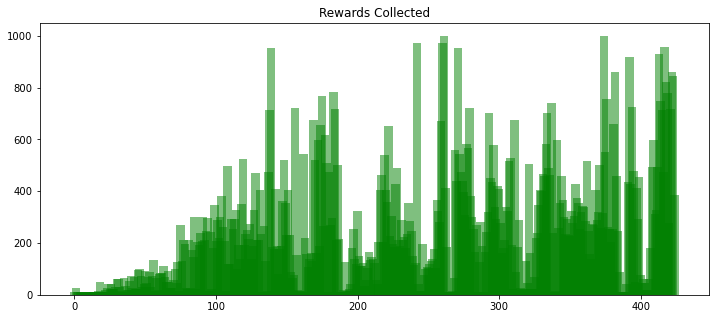

In [13]:
plt.figure(figsize=(12,5))
plt.title("Rewards Collected")
plt.bar(np.arange(len(steps_total)), steps_total, alpha=0.5, color='green', width=6)
plt.show()